## Predstavenie datasetu:
* Merania spotreby el. energie jednej domacnosti pocas doby styroch rokov.
* Su v nom udaje o spotrebe energie za kazdu uplynutu minutu.
* Modalita dat je time series
* Jeden zaznam je pre uplunulu minutu spriemerovane merania: spotreba aktivnej energie celej domacnosti, 
spotreba reaktivnej energie celej domacnosti, napatie, intenzita domacnosti a spotreba v3och roznych castiach domu


In [59]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime
import pmdarima as pm
import copy

from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

In [8]:

data = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'date':['Date','Time']},
                infer_datetime_format=True, na_values=['nan','?'])

In [9]:
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
data[[ "Voltage", "Global_intensity"]].plot()

In [ ]:
data[["Global_active_power", "Global_reactive_power"]].plot()

Kolko NaN hodnot:

In [ ]:
data.isna().sum()

Korelacia dat:

In [ ]:
data.corr()

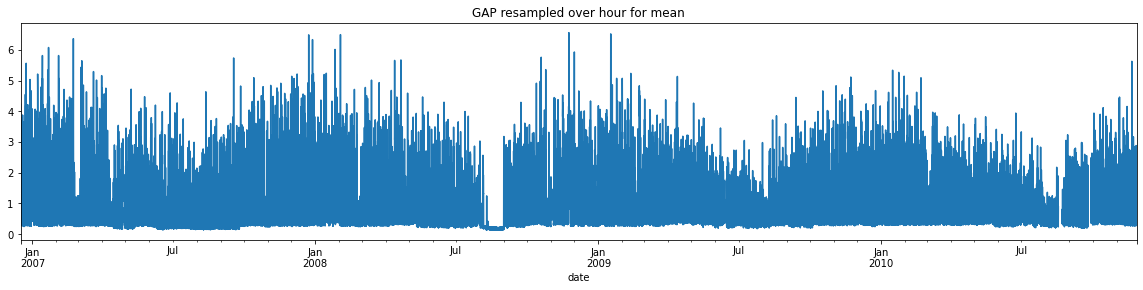

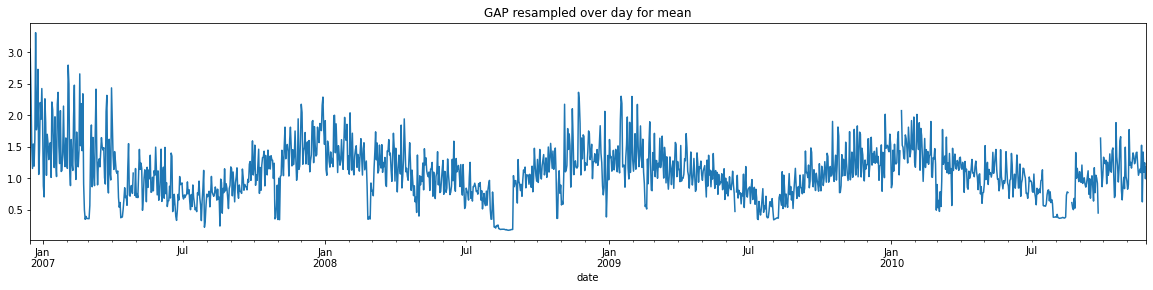

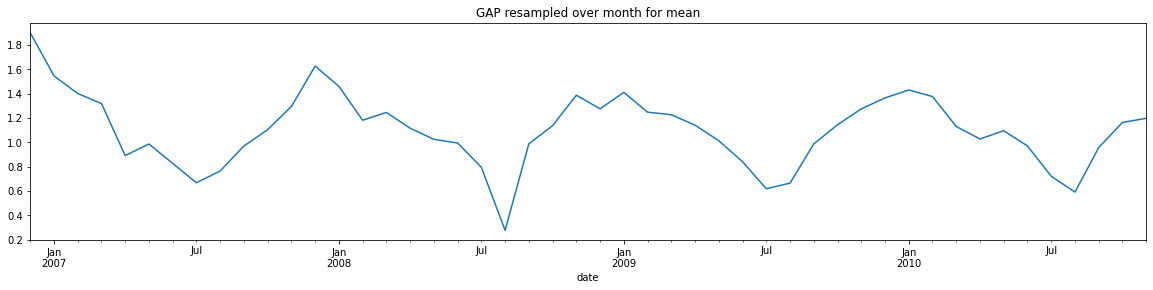

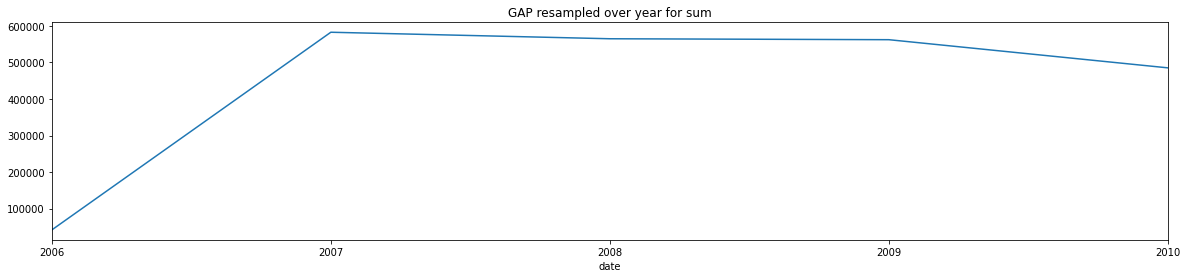

In [15]:
activ_power_daily = data.set_index('date').Global_active_power.resample('D').mean()
activ_power_hourly = data.set_index('date').Global_active_power.resample('H').mean()
activ_power_monthly = data.set_index('date').Global_active_power.resample('M').mean()
activ_power_yearly = data.set_index('date').Global_active_power.resample('Y').mean()

fig = plt.figure(figsize=(20, 4))
activ_power_hourly.plot(title="GAP resampled over hour for mean")
plt.show()


fig = plt.figure(figsize=(20, 4))
activ_power_daily.plot(title="GAP resampled over day for mean")
plt.show()

fig = plt.figure(figsize=(20, 4))
activ_power_monthly.plot(title="GAP resampled over month for mean")
plt.show()

fig = plt.figure(figsize=(20, 4))
data.set_index('date').Global_active_power.resample('Y').sum().plot(title="GAP resampled over year for sum")
plt.show()

## Outliers

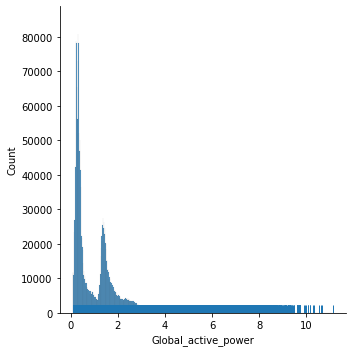

In [16]:
sns.displot(data['Global_active_power'], rug=True)

<AxesSubplot:xlabel='Global_active_power'>

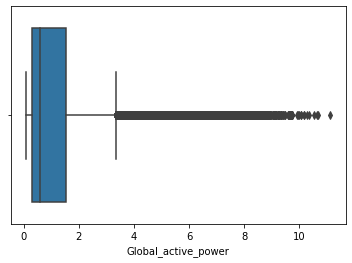

In [17]:
sns.boxplot(x=data['Global_active_power'])

<AxesSubplot:xlabel='Voltage'>

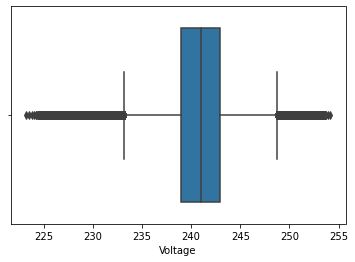

In [18]:
sns.boxplot(x=data['Voltage'])

In [19]:
for i in data.columns:
    print(i)
    print(np.mean(data[i]))

date
2008-12-06 07:12:59.999994112
Global_active_power
1.0916150365006245
Global_reactive_power
0.12371447630387257
Voltage
240.8398579745079
Global_intensity
4.627759310587133
Sub_metering_1
1.1219233096502186
Sub_metering_2
1.2985199679887571
Sub_metering_3
6.45844735712055


In [20]:
data = data.fillna(data.mean())
data.isna().sum()

/tmp/ipykernel_2142/2958962155.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data = data.fillna(data.mean())


date                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Data split and resample

Resample to daily for faster processing.

In [240]:
data_daily = data.set_index('date').resample('D').mean()
data_daily.head()
data_daily.shape

(1442, 7)

In [241]:
train, test = train_test_split(data_daily, test_size=0.33, shuffle = False)

In [242]:
train_X , train_y = train.drop(columns = "Global_active_power"), train["Global_active_power"]
test_X , test_y = test.drop(columns = "Global_active_power"), test["Global_active_power"]
train_size = len(train)
test_size = len(test)
print(train_size, test_size)

966 476


## Baseline model

#### Daily baseline mean

In [39]:
daily_mean = train_y.mean()
baseline_mape = mean_absolute_error([daily_mean] * test_size, test_y)*100
print(baseline_mape)
print(data_daily[data_daily.index == "2006-12-16"]["Global_active_power"].values[0])
print(data_daily[data_daily.index == "2007-12-16"]["Global_active_power"].values[0])
print(data_daily[data_daily.index == "2008-12-16"]["Global_active_power"].values[0])

25.58702443770619
3.0534747474747475
1.9182069444444443
1.2479791666666666


#### Value from previous year

In [40]:
starting_date = datetime.date(2009, 8, 8)
baseline_predict = copy.deepcopy(test_y)
for i in range (test_size):
    date = starting_date
    while date >= datetime.date(2009, 8, 8):
        date = datetime.date(date.year - 1, date.month, date.day)
    sum_power = 0
    count = 0
    while date >= datetime.date(2006, 12, 16):
        dateStr = date.strftime("%Y-%m-%d")
        sum_power += data_daily[data_daily.index == dateStr]["Global_active_power"].values[0]
        count += 1
        date = datetime.date(date.year - 1, date.month, date.day)
    baseline_predict.at[starting_date.strftime("%Y-%m-%d")] = (sum_power / count)
    starting_date = starting_date + datetime.timedelta(days = 1)

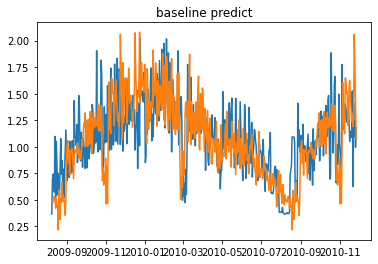

25.366195848561773


In [41]:
plt.plot(test_y)
plt.plot(baseline_predict)
plt.title('baseline predict')
plt.show()

mape_baseline_predict = mean_absolute_error(baseline_predict, test_y)*100
print(mape_baseline_predict)

## ARIMA

### Daily predictions

### Find d value

p value less than 0.05 so we reject null hypothesis that it is non stationary

In [42]:
result = adfuller(data_daily["Global_active_power"], autolag='AIC')
print('p value no diff:', result[1])
result = adfuller(data_daily["Global_active_power"].diff().dropna(), autolag='AIC')
print('p value 1 diff:', result[1])

p value no diff: 0.0039987330043129345
p value 1 diff: 3.2806842760466757e-20


Autocorrelation of 0 order differencing

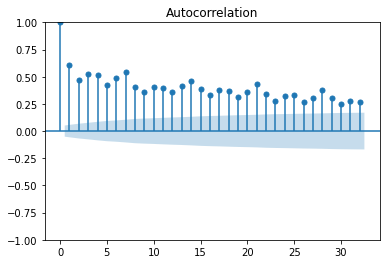

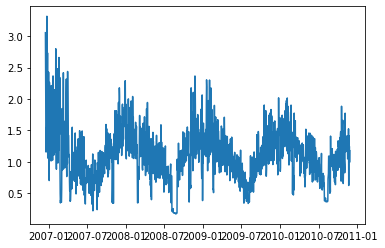

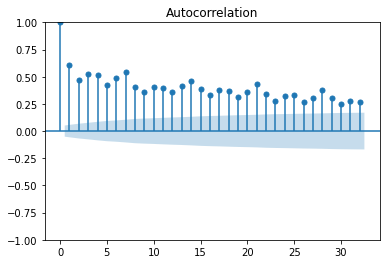

In [43]:
plt.plot(data_daily["Global_active_power"])
plot_acf(data_daily["Global_active_power"])

Autocorrelation of 1 order differencing

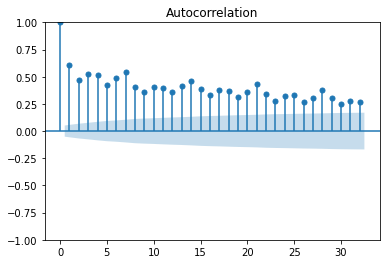

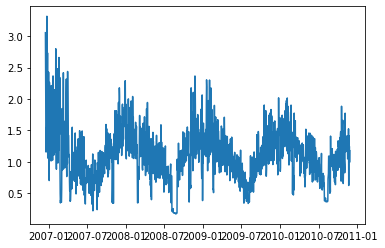

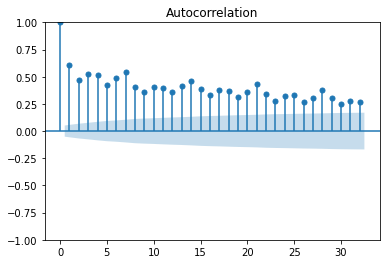

In [218]:
plt.plot(data_daily["Global_active_power"])
plot_acf(data_daily["Global_active_power"].dropna())

 We can see that first order differencing yields better results but we will try both as it might be overdifferenced

### Find p value

/home/rastislav/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


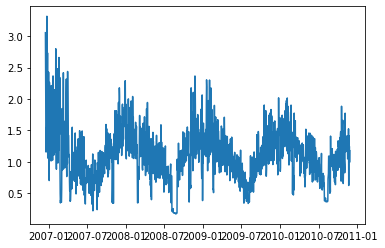

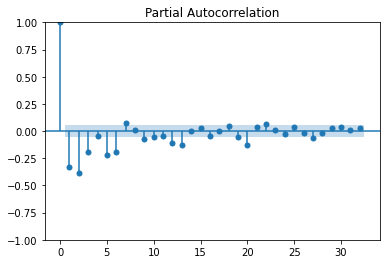

In [47]:
plt.plot(data_daily["Global_active_power"].diff)
sm.graphics.tsa.plot_pacf(data_daily["Global_active_power"].diff().dropna())
plt.show()

/home/rastislav/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


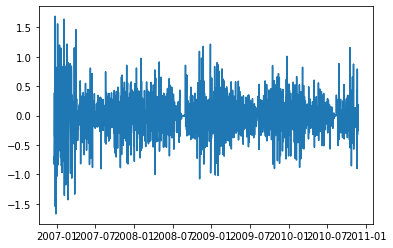

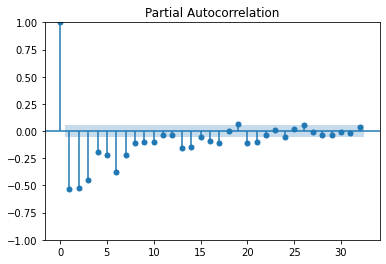

In [46]:
plt.plot(data_daily["Global_active_power"].diff())
sm.graphics.tsa.plot_pacf(data_daily["Global_active_power"].diff().diff().dropna())
plt.show()

In [ ]:
model = SARIMAX(train_y, order=(0,0,0), seasonal_order=(1, 0, 1, 365))
fitted = model.fit()
print(fitted.summary())
train_forecast = fitted.predict() 
test_forecast = fitted.forecast(train_size) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56254D+00    |proj g|=  1.29406D+01

At iterate    5    f=  1.03524D+00    |proj g|=  1.59827D-01

At iterate   10    f=  9.90312D-01    |proj g|=  3.08249D-01

At iterate   15    f=  9.75019D-01    |proj g|=  2.70668D-02


In [ ]:
plt.plot(train_y)
plt.plot(train_forecast)
plt.title('train set')
plt.show()

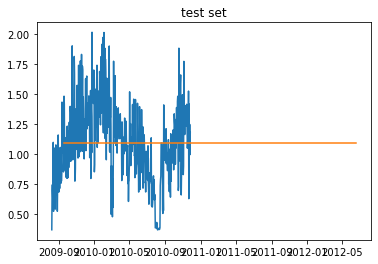

In [245]:
plt.plot(test_y)
plt.plot(test_forecast)
plt.title('test set')
plt.show()

#### MAPE

In [83]:
mape = mean_absolute_error(test_forecast[0:test_size], test_y)*100
print(mape)

24.45244630199727


### Auto arima

In [ ]:
model = pm.auto_arima(train_y, start_p=1, start_q=1,
                      test='adf',      
                      max_p=3, max_q=3, 
                      m=365,              
                      d=None,           
                      seasonal=True,   
                      start_P=0, 
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

### Seasonal Arima weekly

In [126]:
data_weekly = data.set_index('date').resample('W').mean()
data_weekly.head()
data_weekly.shape

(207, 7)

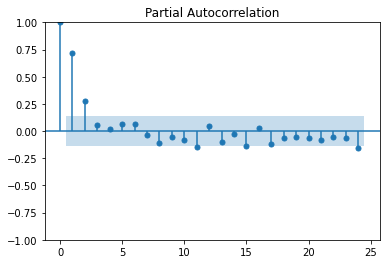

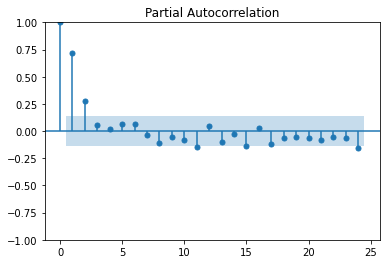

In [220]:
sm.graphics.tsa.plot_pacf(data_weekly["Global_active_power"])


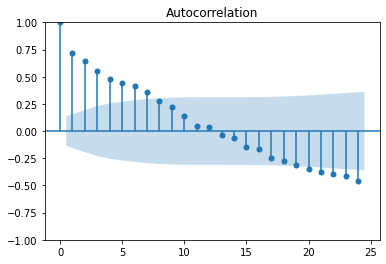

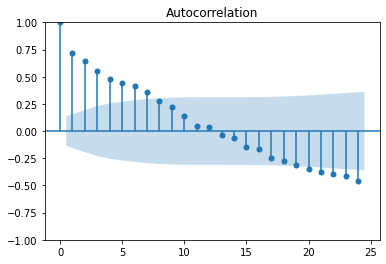

In [221]:
plot_acf(data_weekly["Global_active_power"])

In [127]:
train, test = train_test_split(data_weekly, test_size=0.3, shuffle = False)

In [128]:
train_X , train_y = train.drop(columns = "Global_active_power"), train["Global_active_power"]
test_X , test_y = test.drop(columns = "Global_active_power"), test["Global_active_power"]
train_size = len(train)
test_size = len(test)
print(train_size, test_size)

144 63


In [234]:
model = ARIMA(train_y, order=(0,0,0), seasonal_order=(1, 0, 1, 52))
fitted = model.fit()
print(fitted.summary())
train_forecast = fitted.predict() 
test_forecast = fitted.forecast(train_size) 

                                SARIMAX Results                                 
Dep. Variable:      Global_active_power   No. Observations:                  144
Model:             ARIMA(1, 0, [1], 52)   Log Likelihood                 -22.863
Date:                  Thu, 05 May 2022   AIC                             53.726
Time:                          15:39:54   BIC                             65.606
Sample:                      12-17-2006   HQIC                            58.553
                           - 09-13-2009                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1038      0.044     25.327      0.000       1.018       1.189
ar.S.L52       0.8279      0.089      9.330      0.000       0.654       1.002
ma.S.L52      -0.2260      0.207    

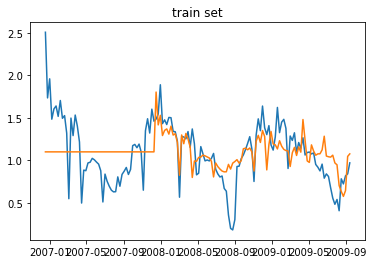

In [231]:
plt.plot(train_y)
plt.plot(train_forecast)
plt.title('train set')
plt.show()

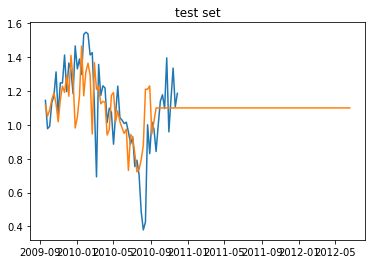

In [232]:
plt.plot(test_y)
plt.plot(test_forecast)
plt.title('test set')
plt.show()

#### MAPE

In [233]:
mape = mean_absolute_error(test_forecast[0:test_size], test_y)*100
print(mape)

15.815872547077706


#### Auto arima

In [208]:
model = pm.auto_arima(train_y + test_y, start_p=0, start_q=0,
                      test='adf',   
                      max_p=1, max_q=1, max_P = 2, max_Q = 2,
                      m=52,              
                      d=None,           
                      seasonal=True,
                      stationary = True,
                      start_P=0, 
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=6.000, Time=2.50 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4.000, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=8.000, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2.000, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6.000, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=6.000, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=8.000, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[52]          
Total fit time: 36.818 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:                        SARIMAX   Log Likelihood                   0.000
Date:     